t時に(t+1時点で処理される)ランダムな買い/売り注文と、t+2時点で買い/売りポジションをクローズするサンプルストラテジーに対するバックテスト例

In [ ]:
# !git clone https://github.com/pondelion/algotham_v2.git

Cloning into 'algotham_v2'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 1), reused 20 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 4.61 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# %cd algotham_v2

/content/algotham_v2


In [1]:
# also can be directly installed from git
!pip install git+https://github.com/pondelion/algotham_v2.git

  Cloning https://github.com/pondelion/algotham_v2.git to /tmp/pip-req-build-49k4tf0r
  Running command git clone --filter=blob:none --quiet https://github.com/pondelion/algotham_v2.git /tmp/pip-req-build-49k4tf0r
  Resolved https://github.com/pondelion/algotham_v2.git to commit 6196d74de64f9a9612416bcf56559fcec035579e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.8 MB/s eta 0:00:00
  Created wheel for algotham-v2: filename=algotham_v2-0.1.0-py3-none-any.whl size=5783 sha256=083418e46739e56642225092824aea535559421678228ea56d636c9de020b94c
  Stored in directory: /tmp/pip-ephem-wheel-cache-u4dzybsj/wheels/7c/13/19/c724d6a6e5fd5c6b031290cabc38a1797eccade8aafc38cf8c
Successfully built algotham-v2
  Attempting uninstall: pandas
    Found existing installation: 

In [2]:
from typing import Optional

import numpy as np
import pandas as pd

from algotham.backtest import BackTest
from algotham.order import Order
from algotham.portfolio import Portfolio
from algotham.strategy import BaseStrategy

## define custom strategy

In [3]:
class SampleStrategy(BaseStrategy):
    def next(self, dt_idx: pd.Timestamp, idx: int, bt: "BackTest"):
        print(idx, dt_idx, bt.df_ref_data["btcjpy_buy"].loc[dt_idx]["price_mean"])  # type: ignore
        if idx < 20:
            return
        # using past 20 periods feature data for prediction
        s_idx = idx + 1 - 20
        e_idx = idx + 1
        df_feat = bt.df_ref_data["btcjpy_buy"].iloc[s_idx:e_idx]  # type: ignore
        assert df_feat.index.max() == dt_idx, (
            "index mismatch",
            df_feat.index.max(),
            dt_idx,
        )
        pred = self._mock_daily_prediction(df_feat)
        if pred == 1:
            order = bt.buy(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_buy"]["price_ohlc_open"],  # type: ignore
                abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
                execution_lag=1,
            )
            order_close = bt.close_long(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_sell"]["price_ohlc_open"],  # type: ignore
                # abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
                execution_lag=2,
                close_target_order_id=order.order_id,
            )
            # print(order)
        elif pred == -1:
            order = bt.sell(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_sell"]["price_ohlc_open"],  # type: ignore
                abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
                execution_lag=1,
            )
            order_close = bt.close_short(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_buy"]["price_ohlc_open"],  # type: ignore
                # abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
                execution_lag=2,
                close_target_order_id=order.order_id,
            )
            # print(order)

    def _mock_daily_prediction(self, df_feat: pd.DataFrame) -> int:
        rnd = np.random.random()
        if rnd <= 0.1:
            return 1  # buy
        elif rnd < 0.9:
            return 0  # do nothing
        else:
            return -1  # sell

    def on_order_accepted(
        self, order: Order, bt: "BackTest", dt_idx: Optional[pd.Timestamp] = None
    ):
        print(f"[{dt_idx}] on_order_accepted {order.order_type}, {order.order_id}")

    def on_order_processed(
        self, order: Order, bt: "BackTest", dt_idx: Optional[pd.Timestamp] = None
    ):
        print(f"[{dt_idx}] on_order_processed {order.order_type}, {order.order_id}")

## prepare data

In [4]:
BTCJPY_BUY_SAMPLE_DATA_URL = "https://github.com/pondelion/algotham_v2/raw/main/data/sample/sample_btcjpy_buy_5min_230601.csv.gzip"
BTCJPY_SELL_SAMPLE_DATA_URL = "https://github.com/pondelion/algotham_v2/raw/main/data/sample/sample_btcjpy_sell_5min_230601.csv.gzip"
df_btcjpy_buy = pd.read_csv(BTCJPY_BUY_SAMPLE_DATA_URL, compression="gzip")
df_btcjpy_sell = pd.read_csv(BTCJPY_SELL_SAMPLE_DATA_URL, compression="gzip")
df_btcjpy_buy["timestamp"] = pd.to_datetime(
    df_btcjpy_buy["timestamp"], utc=True
)
df_btcjpy_sell["timestamp"] = pd.to_datetime(
    df_btcjpy_sell["timestamp"], utc=True
)
df_btcjpy_buy = df_btcjpy_buy.set_index("timestamp")
df_btcjpy_sell = df_btcjpy_sell.set_index("timestamp")
assert (df_btcjpy_buy.index == df_btcjpy_sell.index).all()

In [5]:
df_btcjpy_buy

,size_mean,size_std,size_count,size_sum,size_ohlc_open,size_ohlc_high,size_ohlc_low,size_ohlc_close,price_mean,price_std,price_count,price_sum,price_ohlc_open,price_ohlc_high,price_ohlc_low,price_ohlc_close,side
timestamp,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00+00:00,0.021316,0.018624,38,0.81,0.04,0.10,0.01,0.02,3.793691e+06,982.818905,38,144160259.0,3795000.0,3795870.0,3792393.0,3793646.0,BUY
2023-06-01 00:05:00+00:00,0.041795,0.065730,39,1.63,0.08,0.30,0.01,0.01,3.795227e+06,1316.383997,39,148013837.0,3794250.0,3798190.0,3793760.0,3798165.0,BUY
2023-06-01 00:10:00+00:00,0.020732,0.020173,41,0.85,0.01,0.10,0.01,0.01,3.797244e+06,1566.893200,41,155686987.0,3798244.0,3799754.0,3795042.0,3799754.0,BUY
2023-06-01 00:15:00+00:00,0.032753,0.066662,178,5.83,0.01,0.60,0.01,0.10,3.809042e+06,3648.470246,178,678009549.0,3800000.0,3815304.0,3800000.0,3811065.0,BUY
2023-06-01 00:20:00+00:00,0.046792,0.127094,53,2.48,0.02,0.92,0.01,0.03,3.810780e+06,1484.707985,53,201971344.0,3810904.0,3813785.0,3809041.0,3809145.0,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:40:00+00:00,0.010000,0.000000,8,0.08,0.01,0.01,0.01,0.01,5.243878e+06,574.102514,8,41951027.0,5243431.0,5244923.0,5243431.0,5244434.0,BUY
2023-10-31 20:45:00+00:00,0.029512,0.034853,41,1.21,0.01,0.19,0.01,0.03,5.248075e+06,2740.903236,41,215171077.0,5243297.0,5251520.0,5243297.0,5248500.0,BUY
2023-10-31 20:50:00+00:00,0.033767,0.114272,146,4.93,0.01,1.36,0.01,0.01,5.256848e+06,4039.464558,146,767499808.0,5247600.0,5263568.0,5247500.0,5258378.0,BUY


In [6]:
df_btcjpy_sell

,size_mean,size_std,size_count,size_sum,size_ohlc_open,size_ohlc_high,size_ohlc_low,size_ohlc_close,price_mean,price_std,price_count,price_sum,price_ohlc_open,price_ohlc_high,price_ohlc_low,price_ohlc_close,side
timestamp,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00+00:00,0.030962,0.045299,52,1.61,0.18,0.21,0.01,0.01,3.793640e+06,1198.257262,52,197269298.0,3795322.0,3795674.0,3791414.0,3793532.0,SELL
2023-06-01 00:05:00+00:00,0.020476,0.019500,42,0.86,0.01,0.10,0.01,0.01,3.794938e+06,1633.973553,42,159387375.0,3792862.0,3797535.0,3792862.0,3796640.0,SELL
2023-06-01 00:10:00+00:00,0.027500,0.047845,24,0.66,0.03,0.24,0.01,0.24,3.796753e+06,1146.860807,24,91122076.0,3798538.0,3798809.0,3793821.0,3798809.0,SELL
2023-06-01 00:15:00+00:00,0.029680,0.037673,125,3.71,0.01,0.28,0.01,0.01,3.810195e+06,2689.775982,125,476274313.0,3800544.0,3813778.0,3800396.0,3810115.0,SELL
2023-06-01 00:20:00+00:00,0.038519,0.074312,54,2.08,0.01,0.39,0.01,0.02,3.810350e+06,1132.692863,54,205758875.0,3809741.0,3812630.0,3808353.0,3808354.0,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:40:00+00:00,0.022778,0.020236,18,0.41,0.01,0.09,0.01,0.09,5.241730e+06,832.985435,18,94351149.0,5244446.0,5244446.0,5241085.0,5241085.0,SELL
2023-10-31 20:45:00+00:00,0.022553,0.019833,47,1.06,0.01,0.09,0.01,0.09,5.245329e+06,3051.236704,47,246530442.0,5241351.0,5248401.0,5241085.0,5247200.0,SELL
2023-10-31 20:50:00+00:00,0.028142,0.089168,113,3.18,0.01,0.95,0.01,0.01,5.257143e+06,2728.215978,113,594057172.0,5248770.0,5260210.0,5248003.0,5255801.0,SELL


## init portofolio

In [7]:
pf = Portfolio(init_cash=1000 * 10000)

## run backtest

In [8]:
N_PERIODS = 500  # simulate only latest 500 data

In [9]:
bt = BackTest(
    dt_index=df_btcjpy_buy[-N_PERIODS:].index,  # type: ignore
    strategy=SampleStrategy(),
    init_portfolio=pf,
    df_ref_data={
        "btcjpy_buy": df_btcjpy_buy[-N_PERIODS:],
        "btcjpy_sell": df_btcjpy_sell[-N_PERIODS:],
    },  # optional. if you want to access data from strategy via function param bt.df_ref_data, specify like this.
)

In [10]:
bt.run()

0 2023-10-30 03:25:00+00:00 5135039.352941177
1 2023-10-30 03:30:00+00:00 5135383.761904762
2 2023-10-30 03:35:00+00:00 5134739.625
3 2023-10-30 03:40:00+00:00 5136801.0
4 2023-10-30 03:45:00+00:00 5137357.666666667
5 2023-10-30 03:50:00+00:00 5138645.476190476
6 2023-10-30 03:55:00+00:00 5137683.0
7 2023-10-30 04:00:00+00:00 5137419.0
8 2023-10-30 04:05:00+00:00 5132217.0
9 2023-10-30 04:10:00+00:00 5136596.142857143
10 2023-10-30 04:15:00+00:00 5140932.609375
11 2023-10-30 04:20:00+00:00 5143900.547619048
12 2023-10-30 04:25:00+00:00 5144405.75
13 2023-10-30 04:30:00+00:00 5144078.166666667
14 2023-10-30 04:35:00+00:00 5143587.25
15 2023-10-30 04:40:00+00:00 5146035.0
16 2023-10-30 04:45:00+00:00 5147303.454545454
17 2023-10-30 04:50:00+00:00 5147995.2
18 2023-10-30 04:55:00+00:00 5146942.5
19 2023-10-30 05:00:00+00:00 5146825.666666667
20 2023-10-30 05:05:00+00:00 5145252.5
21 2023-10-30 05:10:00+00:00 5149221.833333333
22 2023-10-30 05:15:00+00:00 5147694.461538462
23 2023-10-30 05

## asset history

In [11]:
df_evaluated_assets_hitory = pf.evaluated_assets_hitory(
    ref_prices={"BTC_JPY": df_btcjpy_sell["price_mean"]}
)

In [12]:
df_evaluated_assets_hitory

,cash,BTC_JPY,evaluated_cash_BTC_JPY,total_evaluated_cash,pnl
datetime,,,,,
2023-10-30 03:25:00+00:00,10000000.00,0.0,0.0,10000000.00,0.00
2023-10-30 03:30:00+00:00,10000000.00,0.0,0.0,10000000.00,0.00
2023-10-30 03:35:00+00:00,10000000.00,0.0,0.0,10000000.00,0.00
2023-10-30 03:40:00+00:00,10000000.00,0.0,0.0,10000000.00,0.00
2023-10-30 03:45:00+00:00,10000000.00,0.0,0.0,10000000.00,0.00
...,...,...,...,...,...
2023-10-31 20:40:00+00:00,9999393.26,0.0,0.0,9999393.26,-606.74
2023-10-31 20:45:00+00:00,9999393.26,0.0,0.0,9999393.26,-606.74
2023-10-31 20:50:00+00:00,9999393.26,0.0,0.0,9999393.26,-606.74


<Axes: xlabel='datetime'>

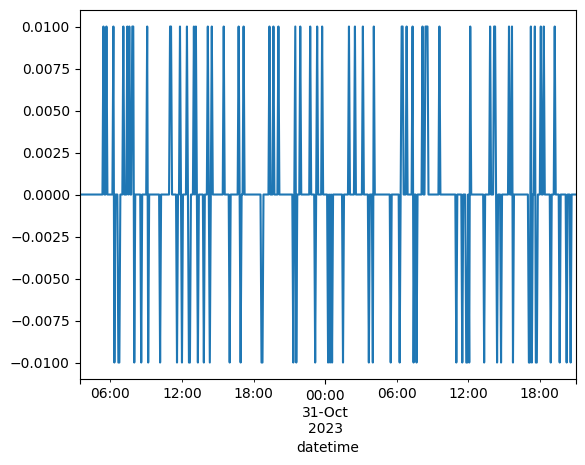

In [13]:
df_evaluated_assets_hitory['BTC_JPY'].plot()

<Axes: xlabel='datetime'>

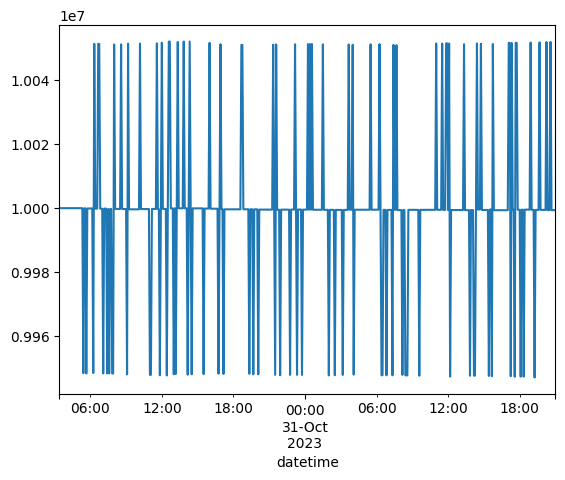

In [14]:
df_evaluated_assets_hitory['cash'].plot()

<Axes: xlabel='datetime'>

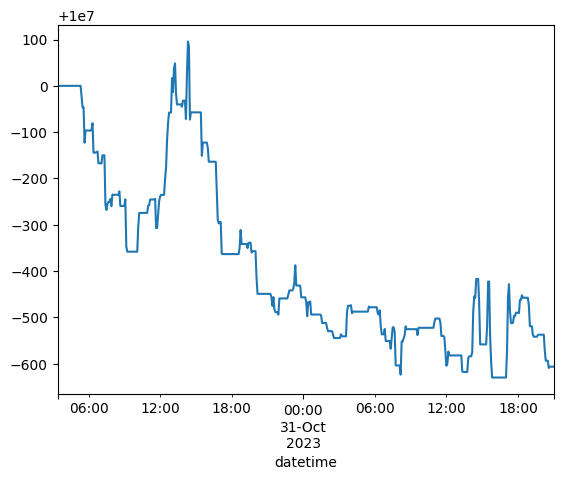

In [15]:
df_evaluated_assets_hitory['total_evaluated_cash'].plot()

<Axes: xlabel='datetime'>

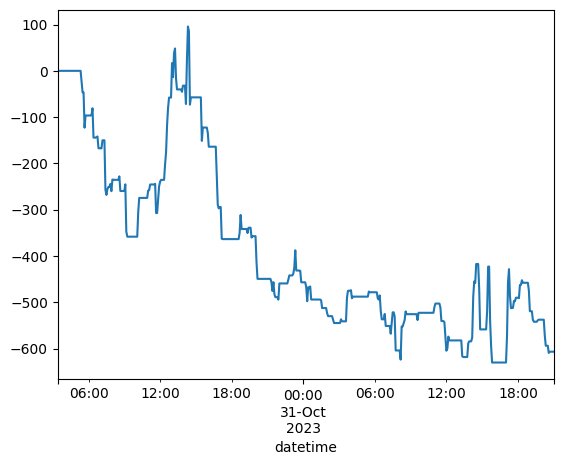

In [16]:
df_evaluated_assets_hitory['pnl'].plot()  # total profit/loss

## order history

In [17]:
df_order_history = bt.order_history

In [18]:
df_order_history

,order_type,asset_name,ordered_timestamp,price_at_ordertime,execution_timestamp,abs_size,executed_timestamp,executed_price,executed_size,status,order_id,close_target_order_id
0,OrderType.BUY,BTC_JPY,2023-10-30 05:20:00+00:00,5144922.0,2023-10-30 05:25:00+00:00,0.01,2023-10-30 05:25:00+00:00,5143799.0,0.01,OrderStatus.PROCESSED,6752dcf9-46af-409c-9834-74ed8894d9a6,None
1,OrderType.CLOSE_LONG,BTC_JPY,2023-10-30 05:20:00+00:00,5142754.0,2023-10-30 05:30:00+00:00,NaN,2023-10-30 05:30:00+00:00,5139150.0,0.01,OrderStatus.PROCESSED,e624f272-dafa-4011-9b9f-f7fc955c0819,6752dcf9-46af-409c-9834-74ed8894d9a6
2,OrderType.BUY,BTC_JPY,2023-10-30 05:35:00+00:00,5138662.0,2023-10-30 05:40:00+00:00,0.01,2023-10-30 05:40:00+00:00,5148403.0,0.01,OrderStatus.PROCESSED,c6dc9a95-efba-4921-9d9c-42d96ec2f449,None
3,OrderType.CLOSE_LONG,BTC_JPY,2023-10-30 05:35:00+00:00,5137864.0,2023-10-30 05:45:00+00:00,NaN,2023-10-30 05:45:00+00:00,5143400.0,0.01,OrderStatus.PROCESSED,11f7805b-1f36-4bac-bcd9-6d9b76d54a89,c6dc9a95-efba-4921-9d9c-42d96ec2f449
4,OrderType.BUY,BTC_JPY,2023-10-30 06:10:00+00:00,5137836.0,2023-10-30 06:15:00+00:00,0.01,2023-10-30 06:15:00+00:00,5130487.0,0.01,OrderStatus.PROCESSED,59926946-ba09-4b12-aef3-df063c3c0648,None
...,...,...,...,...,...,...,...,...,...,...,...,...
197,OrderType.CLOSE_SHORT,BTC_JPY,2023-10-31 19:35:00+00:00,5225541.0,2023-10-31 19:45:00+00:00,NaN,NaT,5222750.0,0.01,OrderStatus.PROCESSED,e2ec73fd-22d3-4ac2-97f7-c6b288ff9517,6347e3e7-608e-4c94-9414-017312a43efb
198,OrderType.SELL,BTC_JPY,2023-10-31 20:10:00+00:00,5234140.0,2023-10-31 20:15:00+00:00,0.01,2023-10-31 20:15:00+00:00,5232377.0,0.01,OrderStatus.PROCESSED,596e00fe-1e9a-436a-96fa-af2e5bee58c7,None
199,OrderType.CLOSE_SHORT,BTC_JPY,2023-10-31 20:10:00+00:00,5235701.0,2023-10-31 20:20:00+00:00,NaN,NaT,5238000.0,0.01,OrderStatus.PROCESSED,9e6e2053-6956-4a90-a1aa-0d71d5b62677,596e00fe-1e9a-436a-96fa-af2e5bee58c7
200,OrderType.SELL,BTC_JPY,2023-10-31 20:30:00+00:00,5247742.0,2023-10-31 20:35:00+00:00,0.01,2023-10-31 20:35:00+00:00,5242137.0,0.01,OrderStatus.PROCESSED,994eacf7-371a-49c2-994c-891bcc9aae54,None
